In [10]:
import scipy
from scipy.stats import wilcoxon, ttest_rel, ttest_ind, ttest_1samp, mannwhitneyu, spearmanr, pearsonr
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib
import os
import pickle
import os, fnmatch
from os import listdir
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
from pylab import*
from scipy.io import wavfile

In [11]:
get_ipython().run_line_magic('cd', '/Users/deepanshishokeen/desktop/capstone/work/amplitude-modulation-analysis-module')
from am_analysis import am_analysis as ama
mpl=matplotlib.pyplot
mod_feat = 'power_modulation_spectrogram' # Controls which version of the amplitude modulation spectrogram


/Users/deepanshishokeen/Desktop/Capstone/work/amplitude-modulation-analysis-module


In [12]:
power_rms = lambda x: np.sqrt(x.mean())
rms = lambda x: np.sqrt(np.square(x).mean())
dB = lambda y: 10*np.log10(y)
objfun = lambda x: dB((np.median(x,0).squeeze()/power_rms(x))+10**(-12)) 

def TTEST(x,y): 
    return mannwhitneyu(objfun(x.squeeze()),objfun(y.squeeze())) 

In [13]:
def stats(mod_spec, f_range=np.array([500,4000]), modf_range=np.array([30,60]), c_range=np.array([20,80]), ttl=None, avg=False, ref=None, hist=False):
    mn=mod_spec[mod_feat] # MN is the M x N modulation envelope
    amx=mod_spec['freq_mod_axis']
    amy=mod_spec['freq_axis']
    midx=np.where((amx>=modf_range[0]) & (amx<modf_range[1]))[0]
    midy=np.where((amy>=f_range[0]) & (amy<f_range[1]))[0]
    if ref is None: 
        rf=mn
    else:
        rf=ref
    w=TTEST(mn[midy][:,midx,:],rf[midy][:,midx,:])
    print(w)
    p=w[1]
    T=w[0]
    #m= p*T
    print(p,T)
    return p,T


In [14]:
def stats_avg_mod(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', t_range=None, FL=2, FR=1, N=1024):
    fs,x = scipy.io.wavfile.read(fname, mmap=True)
    win_size = int(fs*FL)
    win_shift = int(fs/FR)
    if t_range is None:
        t_range = [60,120]
    sig = x[t_range[0]*fs:t_range[1]*fs,0].reshape(-1,1) # LEFT CHANNEL
    sig = sig / rms(sig)# normalize RMS 
    x_segmented, _, _ = ama.epoching(sig, win_size, win_size-win_shift)
    n_segments  = x_segmented.shape[2]
    mod_spec = []
    for i_segment in range(0,n_segments):
        x_tmp = x_segmented[:,:,i_segment]
        ms=ama.strfft_modulation_spectrogram(x_tmp, fs, N, int(fs*0.005))
        mod_spec.append(ms)
    data = []
    for m in mod_spec:    
        data.append(m[mod_feat][:,:,0])
    data = np.array(data)    
    nmm = data.mean(0) # average modulation spectrum
    mod_spec[0][mod_feat][:,:,0]=nmm
    return mod_spec[0]

In [15]:
matplotlib.rcParams['figure.figsize']=(12,6)
def make_reference_mod_spec(x):
    y=np.array([r[mod_feat] for r in x]).mean(0)
    return y

In [16]:
def get_values(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', T=[0,1,2], ttl='Mozart K.448', plotting=True, ref=None):
    res = []
    gr  = []
    for t in T:
        res.append(stats_avg_mod(fname=fname, t_range=[t*60,(t+1)*60]))
        if plotting:
                z= stats(res[t], ref=ref)  
                gr.append(z)
                m=max(gr)
                p = m[0]
                T = m[1]
    return res,p,T

In [17]:
res_448,p,t = get_values('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav')


MannwhitneyuResult(statistic=1740.5, pvalue=0.4989262789424854)
0.4989262789424854 1740.5
MannwhitneyuResult(statistic=1740.5, pvalue=0.4989262789424854)
0.4989262789424854 1740.5
MannwhitneyuResult(statistic=1740.5, pvalue=0.4989262789424854)
0.4989262789424854 1740.5


In [18]:
ref_448 = make_reference_mod_spec(res_448)
res,p,t = get_values('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav', ttl='Mozart K545', ref=ref_448)


MannwhitneyuResult(statistic=420.0, pvalue=6.033983115530341e-13)
6.033983115530341e-13 420.0
MannwhitneyuResult(statistic=1488.0, pvalue=0.08749694638880912)
0.08749694638880912 1488.0
MannwhitneyuResult(statistic=1210.0, pvalue=0.0021681528383346474)
0.0021681528383346474 1210.0


In [13]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Non-western'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,p,t=get_values(whole_path,ttl=ttl, ref=ref_448)
        z=ttl,p,t
        my_list.append(z)
    

MannwhitneyuResult(statistic=1205.0, pvalue=0.001991454864787087)
0.001991454864787087 1205.0
MannwhitneyuResult(statistic=1312.0, pvalue=0.010622281259857765)
0.010622281259857765 1312.0
MannwhitneyuResult(statistic=908.0, pvalue=3.7664855985488535e-06)
3.7664855985488535e-06 908.0
MannwhitneyuResult(statistic=971.0, pvalue=1.7444013541648364e-05)
1.7444013541648364e-05 971.0
MannwhitneyuResult(statistic=475.0, pvalue=4.928815780424081e-12)
4.928815780424081e-12 475.0
MannwhitneyuResult(statistic=711.0, pvalue=1.5266610304053185e-08)
1.5266610304053185e-08 711.0
MannwhitneyuResult(statistic=213.0, pvalue=1.0284359846620806e-16)
1.0284359846620806e-16 213.0
MannwhitneyuResult(statistic=353.0, pvalue=4.1585807526493354e-14)
4.1585807526493354e-14 353.0
MannwhitneyuResult(statistic=1700.0, pvalue=0.4147703685423776)
0.4147703685423776 1700.0
MannwhitneyuResult(statistic=44.0, pvalue=3.478441175581847e-20)
3.478441175581847e-20 44.0
MannwhitneyuResult(statistic=305.0, pvalue=5.65663232407

In [14]:
import pandas as pd
df=pd.DataFrame(my_list, columns=['Title', 'Pvalue', 'Tstatistics' ])
df=df.sort_values(by=['Tstatistics'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/Non-western.xlsx')  

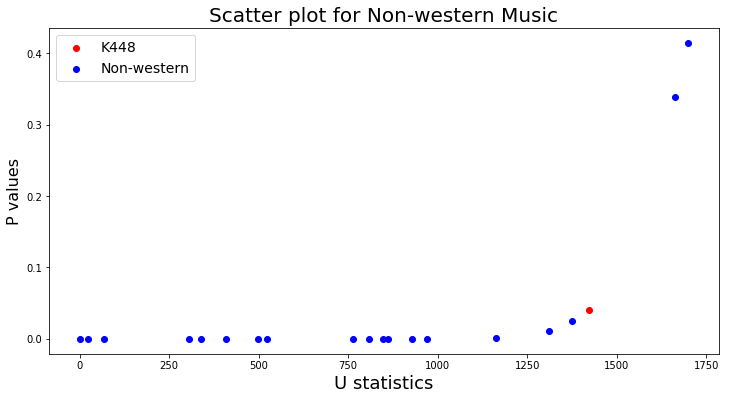

In [33]:
df = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/Non-western.xlsx')
g1=df.Pvalue
g1.shape
g2=df.Tstatistics
g2.shape

k448=plt.scatter(1422,0.04,color='red')#k448
rnr=plt.scatter(g2,g1,color='blue')
plt.legend((k448, rnr),
           ('K448', 'Non-western'),
           scatterpoints=1,
           fontsize=14)
plt.title('Scatter plot for Non-western Music', fontsize=20)
plt.xlabel('U statistics', fontsize=18)
plt.ylabel('P values', fontsize=16)
plt.show()

In [15]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Ambient Music'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,p,t=get_values(whole_path,ttl=ttl, ref=ref_448)
        z=ttl,p,t
        my_list.append(z)


MannwhitneyuResult(statistic=1183.0, pvalue=0.0013591362734606345)
0.0013591362734606345 1183.0
MannwhitneyuResult(statistic=626.0, pvalue=1.0121566927114994e-09)
1.0121566927114994e-09 626.0
MannwhitneyuResult(statistic=193.0, pvalue=4.168125834456015e-17)
4.168125834456015e-17 193.0
MannwhitneyuResult(statistic=1670.0, pvalue=0.3531765060813923)
0.3531765060813923 1670.0
MannwhitneyuResult(statistic=1461.0, pvalue=0.06659348749666197)
0.06659348749666197 1461.0
MannwhitneyuResult(statistic=1273.0, pvalue=0.005976682757569433)
0.005976682757569433 1273.0
MannwhitneyuResult(statistic=1.0, pvalue=3.995900955029211e-21)
3.995900955029211e-21 1.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=5.0, pvalue=4.8978537333060254e-21)
4.8978537333060254e-21 5.0
MannwhitneyuResult(statistic=597.0, pvalue=3.827291442085215e-10)
3.827291442085215e-10 597.0
MannwhitneyuResult(statistic=657.0, pvalue=2.7881301121400923e-09)
2.7

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 59 results
  r = func(a, **kwargs)


MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=543.0, pvalue=5.873280186313197e-11)
5.873280186313197e-11 543.0
MannwhitneyuResult(statistic=72.0, pvalue=1.3834449410762042e-19)
1.3834449410762042e-19 72.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=28.0, pvalue=1.5645537567022417e-20)
1.5645537567022417e-20 28.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=9.0, pvalue=6.0006428006017826e-21)
6.0006428006017826e-21 9.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=718.0, pvalue=1.8916946349033948e-08)
1.8916946349033948e-08 718.0
MannwhitneyuResult(statistic=188.0, pvalue=3.319754177237942e-17)
3.319754177237942e-17 188.0
MannwhitneyuResult(statistic=96.0, pvalue=4.437367182650627e-19)
4.437367182650627e-19 96.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=1671.0, pvalue=0.35517862605963235)
0.3551786

In [16]:
import pandas as pd
df=pd.DataFrame(my_list, columns=['Title', 'Pvalue', 'Tstatistics' ])
df=df.sort_values(by=['Tstatistics'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/Ambience.xlsx')  

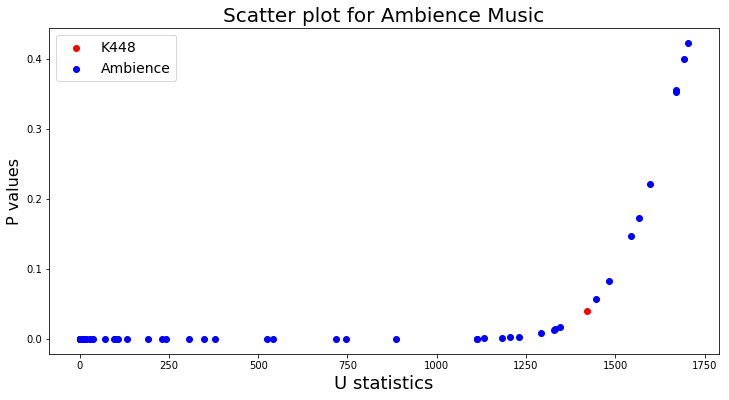

In [32]:
df = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/Ambience.xlsx')
g1=df.Pvalue
g1.shape
g2=df.Tstatistics
g2.shape

k448=plt.scatter(1422,0.04,color='red')#k448
rnr=plt.scatter(g2,g1,color='blue')
plt.legend((k448, rnr),
           ('K448', 'Ambience'),
           scatterpoints=1,
           fontsize=14)
plt.title('Scatter plot for Ambience Music', fontsize=20)
plt.xlabel('U statistics', fontsize=18)
plt.ylabel('P values', fontsize=16)
plt.show()

In [17]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Heavy Metal'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,p,t=get_values(whole_path,ttl=ttl, ref=ref_448)
        z=ttl,p,t
        my_list.append(z)


MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0


/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 59 results
  r = func(a, **kwargs)


MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=1017.0, pvalue=4.9838236473370426e-05)
4.9838236473

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=616.0, pvalue=7.257294343566827e-10)
7.257294343566827e-10 616.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.79739544661

In [18]:
import pandas as pd
df=pd.DataFrame(my_list, columns=['Title', 'Pvalue', 'Tstatistics' ])
df=df.sort_values(by=['Tstatistics'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/heavy_metal.xlsx')  

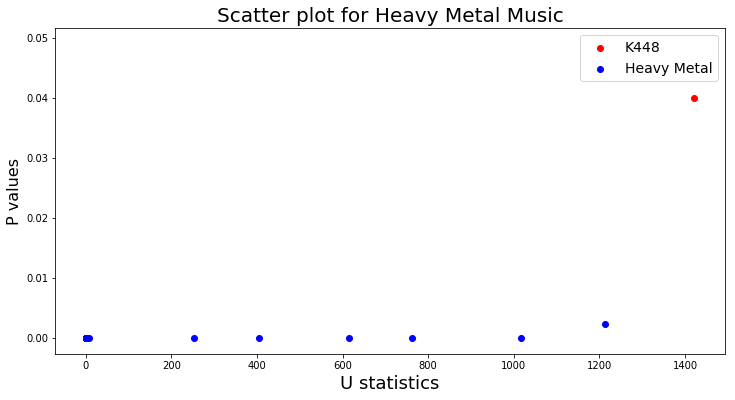

In [29]:
df = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/heavy_metal.xlsx')
g1=df.Pvalue
g1.shape
g2=df.Tstatistics
g2.shape

k448=plt.scatter(1422,0.04,color='red')#k448
rnr=plt.scatter(g2,g1,color='blue')
plt.legend((k448, rnr),
           ('K448', 'Heavy Metal'),
           scatterpoints=1,
           fontsize=14)
plt.title('Scatter plot for Heavy Metal Music', fontsize=20)
plt.xlabel('U statistics', fontsize=18)
plt.ylabel('P values', fontsize=16)
plt.show()

In [19]:
my_list=[]
mypath= "/Volumes/LaCie/Preferred Music Corpus/Rock n' Roll"
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,p,t=get_values(whole_path,ttl=ttl, ref=ref_448)
        z=ttl,p,t
        my_list.append(z)


MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=1411.0, pvalue=0.038299860531344994)
0.038299860531344994 1411.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=6.0, pvalue=5.1531462799208714e-21)
5.1531462799208714e-21 6.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.79739544661

MannwhitneyuResult(statistic=2.0, pvalue=4.204662661948243e-21)
4.204662661948243e-21 2.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.797395446618272

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=384.0, pvalue=1.4565658486754527e-13)
1.4565658486754527e-13 384.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=3.0, pvalue=4.424204115202177e-21)
4.424204115202177e-21 3.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=3.0, pvalue=4.424204115202177e-21)
4.424204115202177e-21 3.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=2.0, pvalue=4.204662661948243e-21)
4.20466266194824

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=5.0, pvalue=4.8978537333060254e-21)
4.8978537333060254e-21 5.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182

MannwhitneyuResult(statistic=71.0, pvalue=1.317395898638408e-19)
1.317395898638408e-19 71.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=44.0, pvalue=3.478441175581847e-20)
3.478441175581847e-20 44.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=112.0, pvalue=9.562897194418603e-19)
9.562897194418603e-19 112.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.79739544661

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=536.0, pvalue=4.57860298259009e-11)
4.57860298259009e-11 536.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 59 results
  r = func(a, **kwargs)


MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=104.0, pvalue=6.520114007681775e-19)
6.520114007681775e-19 104.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.79739544661

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182

In [20]:
import pandas as pd
df=pd.DataFrame(my_list, columns=['Title', 'Pvalue', 'Tstatistics' ])
df=df.sort_values(by=['Tstatistics'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/rock_n_roll.xlsx')  

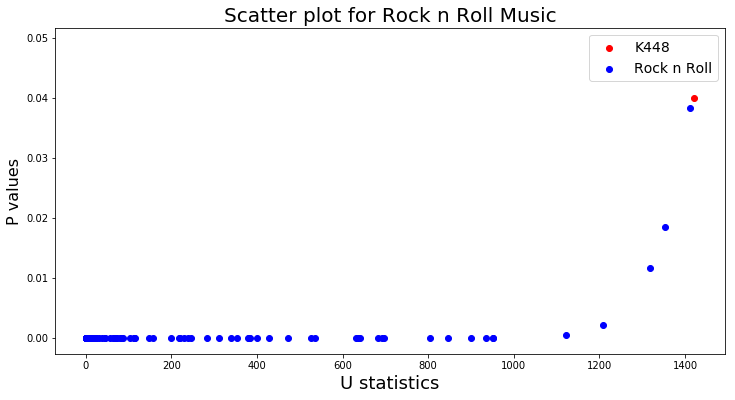

In [30]:
df = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/rock_n_roll.xlsx')
g1=df.Pvalue
g1.shape
g2=df.Tstatistics
g2.shape

k448=plt.scatter(1422,0.04,color='red')#k448
rnr=plt.scatter(g2,g1,color='blue')
plt.legend((k448, rnr),
           ('K448', 'Rock n Roll'),
           scatterpoints=1,
           fontsize=14)
plt.title('Scatter plot for Rock n Roll Music', fontsize=20)
plt.xlabel('U statistics', fontsize=18)
plt.ylabel('P values', fontsize=16)
plt.show()

## FOR CLASSICAL MUSIC

In [19]:
roots=[]
files=[]
my_list=[]
mypath= '/Volumes/LaCie/PSYC90 Corpus Study'
for root, dirnames, filenames in os.walk(mypath):
    for filename in filenames:
        if filename.endswith('.wav') and not filename.startswith("._"):
                files.append(os.path.join(filename))
                roots.append(os.path.join(root,filename))

z = []
slash='/'
for i,j in zip(roots,files)
    ttl=j.replace('.wav','')
    sampFreq, snd = wavfile.read(i)
    if snd.shape[0]/sampFreq > 140: 
        res,p,t=get_values(i,ttl=ttl, ref=ref_448)
        z=ttl,p,t
        my_list.append(z)

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=266.0, pvalue=1.0656196096803224e-15)
1.0656196096803224e-15 266.0
MannwhitneyuResult(statistic=299.0, pvalue=4.3878638325350546e-15)
4.3878638325350546e-15 299.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=390.0, pvalue=1.8506396518316596e-13)
1.850

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=1445.0, pvalue=0.056169362914911536)
0.056169362914911536 1445.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=1320.0, pvalue=0.011893519472320766)
0.011893519472320766 1320.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=287.0, pvalue=2.632117834023677e-15)
2.632117834023677e-15 287.0
MannwhitneyuResult(statistic=32.0, pvalue=1.911778729519524e-20)
1.911778729519524e-20 32.0
MannwhitneyuResult(statistic=970.0, pvalue=1.7039350646832314e-05)
1.70393

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=103.0, pvalue=6.214518267306615e-19)
6.214518267306615e-19 103.0
MannwhitneyuResult(statistic=129.0, pvalue=2.1449090525518434e-18)
2.1449090525518434e-18 129.0
MannwhitneyuResult(statistic=1245.0, pvalue=0.003858336603781426)
0.003858336603781426 1245.0
MannwhitneyuResult(statistic=1474.0, pvalue=0.07611732946032085)
0.07611732946032085 1474.0
MannwhitneyuResult(statistic=1037.0, pvalue=7.724685187992082e-05)
7.724685187992082e-05 1037.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=224.0, pvalue=1.681865970606948e-16)
1.681865970606948e-16 224.0
MannwhitneyuResult(statistic=1411.0, pvalue=0.038299860531344994)
0.038299860531344994 1411.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=167.0, pvalue=1.2665137272231682e-17)
1.2665137272231682e-17 167.0
MannwhitneyuResult(statistic=423.0, pvalue=6.781417674743456e-13)
6.781417674743456e-13 423.0
MannwhitneyuResult(statistic=390.0, pvalue=1.8506396518316596e-13)
1.8506396518316596e-13 390.0
MannwhitneyuResult(statistic=716.0, pvalue=1.7795483409496467e-08)
1.7795483409496467e-08 716.0
MannwhitneyuResult(statistic=798.0, pvalue=1.988093633100521e-07)
1.988093633100521e-07 798.0
MannwhitneyuResult(statistic=1131.0, pvalue=0.0005230978514462064)
0.0005230978514462064 1131.0
MannwhitneyuResult(statistic=597.0, pvalue=3.827291442085215e-10)
3.827291442085215e-10 597.0
MannwhitneyuResult(statistic=1070.0, pvalue=0.00015540592375060903)
0.00015540592375060903 1070.0
MannwhitneyuResult(statistic=1066.0, pvalue=0.00014300793551299913)
0.00014300793551299913 1066.0
MannwhitneyuResult(statistic=389.0, pvalue=1.7

MannwhitneyuResult(statistic=47.0, pvalue=4.0373045816191757e-20)
4.0373045816191757e-20 47.0
MannwhitneyuResult(statistic=324.0, pvalue=1.2557825315757488e-14)
1.2557825315757488e-14 324.0
MannwhitneyuResult(statistic=133.0, pvalue=2.590792974052965e-18)
2.590792974052965e-18 133.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=411.0, pvalue=4.244119022067127e-13)
4.244119022067127e-13 411.0
MannwhitneyuResult(statistic=898.0, pvalue=2.923223260514927e-06)
2.923223260514927e-06 898.0
MannwhitneyuResult(statistic=765.0, pvalue=7.700113701717397e-08)
7.700113701717397e-08 765.0
MannwhitneyuResult(statistic=527.0, pvalue=3.3174091306514125e-11)
3.3174091306514125e-11 527.0
MannwhitneyuResult(statistic=720.0, pvalue=2.0106818245362576e

MannwhitneyuResult(statistic=101.0, pvalue=5.645140255047195e-19)
5.645140255047195e-19 101.0
MannwhitneyuResult(statistic=71.0, pvalue=1.317395898638408e-19)
1.317395898638408e-19 71.0
MannwhitneyuResult(statistic=772.0, pvalue=9.440343822789152e-08)
9.440343822789152e-08 772.0
MannwhitneyuResult(statistic=1578.0, pvalue=0.19162409110850398)
0.19162409110850398 1578.0
MannwhitneyuResult(statistic=1423.0, pvalue=0.043987451588127675)
0.043987451588127675 1423.0
MannwhitneyuResult(statistic=74.0, pvalue=1.5255123170616955e-19)
1.5255123170616955e-19 74.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=203.0, pvalue=6.556614055291652e-17)
6.556614055291652e-17 203.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.797

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=1004.0, pvalue=3.72639826936219e-05)
3.72639826936219e-05 1004.0
MannwhitneyuResult(statistic=1480.0, pvalue=0.08084817080489837)
0.08084817080489837 1480.0
MannwhitneyuResult(statistic=1517.0, pvalue=0.11502205426898143)
0.11502205426898143 1517.0
MannwhitneyuResult(statistic=875.0, pvalue=1.61472402779243e-06)
1.61472402779243e-06 875.0
MannwhitneyuResult(statistic=247.0, pvalue=4.651448426381074e-16)
4.651448426381074e-16 247.0
MannwhitneyuResult(statistic=1009.0, pvalue=4.169610727049428e-05)
4.169610727049428e-05 1009.0
MannwhitneyuResult(statistic=414.0, pvalue=4.773507719566193e-13)
4.773507719566193e-13 414.0
MannwhitneyuResult(statistic=969.0, pvalue=1.6643614199594907e-05)
1.6643614199594907e-05 969.0
MannwhitneyuResult(statistic=801.0, pvalue=2.1638535056125265e-07)
2.1638535056125265e-07 801.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-2

In [20]:
df=pd.DataFrame(my_list, columns=['Title', 'Pvalue', 'Tstatistics' ])
df=df.sort_values(by=['Tstatistics'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/classical.xlsx')  

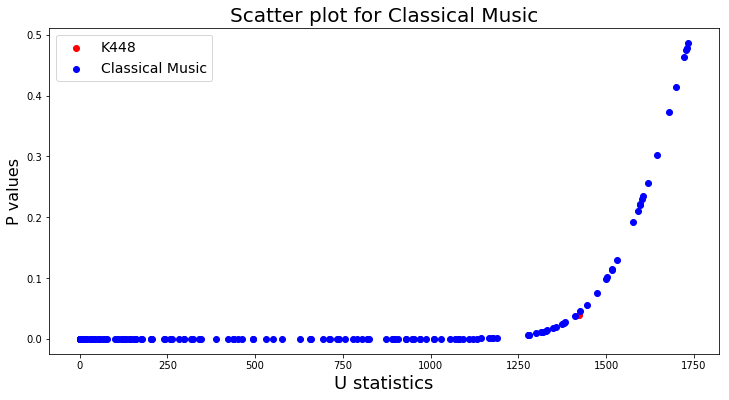

In [31]:
df = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/classical.xlsx')
g1=df.Pvalue
g1.shape
g2=df.Tstatistics
g2.shape

k448=plt.scatter(1422,0.04,color='red')#k448
rnr=plt.scatter(g2,g1,color='blue')
plt.legend((k448, rnr),
           ('K448', 'Classical Music'),
           scatterpoints=1,
           fontsize=14)
plt.title('Scatter plot for Classical Music', fontsize=20)
plt.xlabel('U statistics', fontsize=18)
plt.ylabel('P values', fontsize=16)
plt.show()

In [34]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Country/Classic Country'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,p,t=get_values(whole_path,ttl=ttl, ref=ref_448)
        z=ttl,p,t
        my_list.append(z)


MannwhitneyuResult(statistic=742.0, pvalue=3.904193801308547e-08)
3.904193801308547e-08 742.0
MannwhitneyuResult(statistic=745.0, pvalue=4.269445599288243e-08)
4.269445599288243e-08 745.0
MannwhitneyuResult(statistic=723.0, pvalue=2.2028763150262704e-08)
2.2028763150262704e-08 723.0
MannwhitneyuResult(statistic=155.0, pvalue=7.261235743248243e-18)
7.261235743248243e-18 155.0
MannwhitneyuResult(statistic=112.0, pvalue=9.562897194418603e-19)
9.562897194418603e-19 112.0
MannwhitneyuResult(statistic=4.0, pvalue=4.655075256185421e-21)
4.655075256185421e-21 4.0
MannwhitneyuResult(statistic=438.0, pvalue=1.2112521711899665e-12)
1.2112521711899665e-12 438.0
MannwhitneyuResult(statistic=642.0, pvalue=1.7133684900722006e-09)
1.7133684900722006e-09 642.0
MannwhitneyuResult(statistic=427.0, pvalue=7.920806014307796e-13)
7.920806014307796e-13 427.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=69.0, pvalue=1.1945046782616295

MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=185.0, pvalue=2.895049644469488e-17)
2.895049644469488e-17 185.0
MannwhitneyuResult(statistic=353.0, pvalue=4.1585807526493354e-14)
4.1585807526493354e-14 353.0
MannwhitneyuResult(statistic=1552.0, pvalue=0.15580107689973832)
0.15580107689973832 1552.0
MannwhitneyuResult(statistic=164.0, pvalue=1.1024977831886494e-17)
1.1024977831886494e-17 164.0
MannwhitneyuResult(statistic=153.0, pvalue=6.615612997981158e-18)
6.615612997981158e-18 153.0
MannwhitneyuResult(statistic=13.0, pvalue=7.348363241496412e-21)
7.348363241496412e-21 13.0
MannwhitneyuResult(statistic=246.0, pvalue=4.451599613997991e-16)
4.451599613997991e-16 246.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=31.0, pvalue=1.818421277386902e-20)
1.818421277386902e-20 31.0
MannwhitneyuResult(statistic=60.0, pvalue=7.677047428794833e-20)
7

MannwhitneyuResult(statistic=182.0, pvalue=2.5240291622316165e-17)
2.5240291622316165e-17 182.0
MannwhitneyuResult(statistic=494.0, pvalue=9.980849479846305e-12)
9.980849479846305e-12 494.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=292.0, pvalue=3.2583703045937276e-15)
3.2583703045937276e-15 292.0
MannwhitneyuResult(statistic=132.0, pvalue=2.4714133677405823e-18)
2.4714133677405823e-18 132.0
MannwhitneyuResult(statistic=37.0, pvalue=2.4545201775149072e-20)
2.4545201775149072e-20 37.0
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
3.7973954466182726e-21 0.0
MannwhitneyuResult(statistic=12.0, pvalue=6.985718372082218e-21)
6.985718372082218e-21 12.0
MannwhitneyuResult(statistic=155.0, pvalue=7.261235743248243e-18

In [35]:
df=pd.DataFrame(my_list, columns=['Title', 'Pvalue', 'Tstatistics' ])
df=df.sort_values(by=['Tstatistics'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/classic_country.xlsx')  

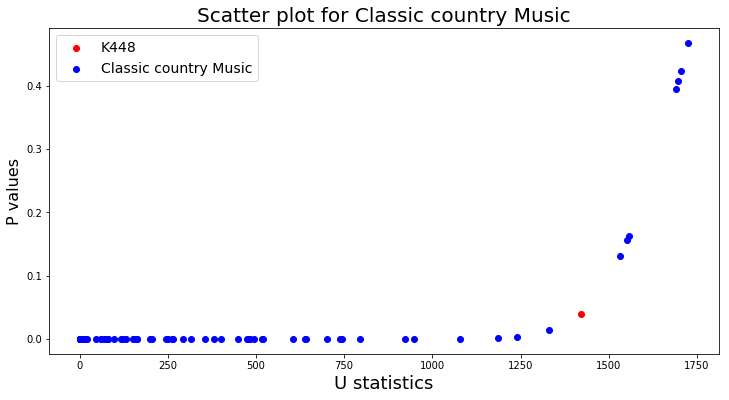

In [38]:
df = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/classic_country.xlsx')
g1=df.Pvalue
g1.shape
g2=df.Tstatistics
g2.shape

k448=plt.scatter(1422,0.04,color='red')#k448
rnr=plt.scatter(g2,g1,color='blue')
plt.legend((k448, rnr),
           ('K448', 'Classic country Music'),
           scatterpoints=1,
           fontsize=14)
plt.title('Scatter plot for Classic country Music', fontsize=20)
plt.xlabel('U statistics', fontsize=18)
plt.ylabel('P values', fontsize=16)
plt.show()

In [23]:
df_nw = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/Non-western.xlsx')
df_amb = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/Ambience.xlsx')
df_hm = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/heavy_metal.xlsx')
df_class = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/classical.xlsx')
df_rnr = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/get_stats/rock_n_roll.xlsx')

In [24]:
df = df_rnr.append(df_amb, ignore_index=True)
df = df.append(df_nw,ignore_index=True)
df = df.append(df_hm,ignore_index=True)
df = df.append(df_class,ignore_index=True)

Text(0,0.5,'count')

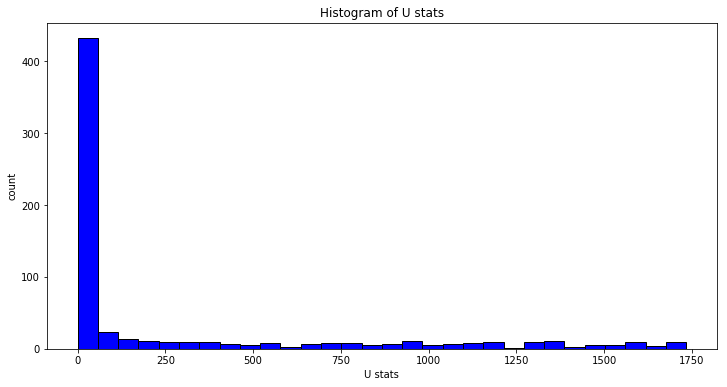

In [28]:
plt.hist(df['Tstatistics'], color = 'blue', edgecolor = 'black', bins=30)
plt.title('Histogram of U stats')
plt.xlabel('U stats')
plt.ylabel('count')